In [1]:
import glob
import gzip
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys

from Bio.Seq import Seq
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.subplots import make_subplots
import seaborn as sns

import matrix_transform
import visualize

%matplotlib inline
sns.set(font="Arial")
sns.set_theme(style="ticks")
colors = ['#D81B60', '#1E88E5', '#FFC107', '#31B547']
sns.set_palette(sns.color_palette(colors))

In [5]:
fig_folder = 'Figures/'
sample_dir = 'sample_spreadsheet_021521.csv'
samples = pd.read_csv(sample_dir)

amino_acid_list = ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
                   'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
                   'S', 'T', 'V', 'W', 'Y']
amino_acid_list.reverse()
grouped_aa = ['H', 'K','R','D','E','C','M','N','Q','S','T','A',\
             'I','L','V','F','W','Y','G','P','*']

wt_ = ('SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDM'
       'LNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTP'
       'KYKFVRIQPGQTFSVLFLNGSCGSVG'
       'FNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTT'
       'ITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDI'
       'LGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ*')
wt_full = ('MSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICT'
           'SEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKV'
           'DTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIK'
           'GSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYG'
           'PFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLND'
           'FNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNG'
           'MNGRTILGSALLEDEFTPFDVVRQCSGVTFQ')
wt_ = [x for x in wt_]
wt_full = [x for x in wt_full]

sets = [1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13,\
        14, 15, 16, 17, 18, 19, 20, 'R1']
set21 = [21]
res_redo = ['8R', '13R1', '13R2', '14R', '16R', '9R1', '9R2',
           '10R1', '10R2']

all_sets = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 20, 21, 8, 9, 10, 'R1',
        '8R', '13R1', '13R2', '14R', '16R', '9R1', '9R2',
        '10R1', '10R2']

### Activity

In [6]:
all_residues = matrix_transform.transform_matrix(
    'new_glu_gal', 'gal_glu.csv', samples, sets, res_redo, all_sets, set21)

visualize.make_heatmap(
        all_residues, [int(x[4:]) for x in list(all_residues.columns)], 
         grouped_aa, wt_full[1:], show = True, save = False)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/glu_gal_matrices/set9R1gal_glu.csv'

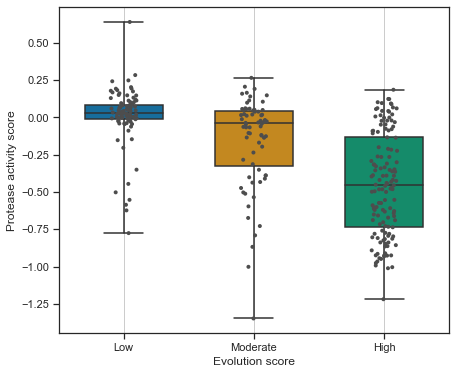

In [4]:
# compute average fitness at each position
residue_x = [int(x[4:]) for x in all_residues.columns]
mean_fitness = all_residues.drop(['*']).mean()
mean_fitness_df = pd.DataFrame(mean_fitness)

# compute rolling average of fitness
for i in range(0,mean_fitness_df.shape[0]-2):
    mean_fitness_df.loc[mean_fitness_df.index[i+2],'rolling_av'] = \
    np.round(((mean_fitness_df.iloc[i,0]+ mean_fitness_df.iloc[i+1,0] 
               + mean_fitness_df.iloc[i+2,0])/3),1)
    
# load rate for evolutionary rates data
r4s = pd.read_csv('CSVs/consurf_3cl_score.csv')
r4s['protease_screen_score'] = list(mean_fitness)
# categorize evolutionary conservation by category
grade = []
for x in r4s['COLOR']:
    if x<=3.0:
        grade.append('Low')
    elif x<=6.0:
        grade.append('Moderate')
    elif x<=9.0:
        grade.append('High')
    else:
        grade.append('none')
r4s['Evolution score'] = grade

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with vertical boxes
sns_plot = sns.boxplot(x="Evolution score", y="protease_screen_score", data=r4s,
            whis=[0, 100], width=.6, palette="colorblind", 
                       order = ['Low', 'Moderate', 'High'])

# Add in points to show each observation
sns.stripplot(x="Evolution score", y="protease_screen_score", data=r4s,
              size=4, color=".3", linewidth=0,
             order = ['Low', 'Moderate', 'High'])

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='Protease activity score')
fig = sns_plot.get_figure()
fig.savefig(fig_folder+"Fig2_evolution_activity.png", dpi=400)

In [26]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}],
                          [{"secondary_y": True}],
                          [{"secondary_y": True}]],
        rows=3, cols=1, vertical_spacing=0.3, 
        subplot_titles=("Window: 3", "Window: 5", "Window: 7"))

for ind, x in enumerate([3,5, 7]):
# Add traces
    fig.add_trace(
                go.Scatter(x=r4s['POS'], y=r4s['SCORE'].rolling(x).mean(), 
                name="Evolutionary score",
                mode='lines'),
                secondary_y=False, 
                row = ind+1, col = 1
    )

    fig.add_trace(
                go.Scatter(x=r4s['POS'], 
                y=r4s['protease_screen_score'].rolling(x).mean(), name="screen",
                mode='lines'),
        secondary_y=True,
        row = ind+1, col = 1
    )


    # Set x-axis title
    fig.update_xaxes(title_text="Residue")
    fig.update_layout(dict(
    template="simple_white",
        xaxis=dict(ticks="outside", showline=True),
        yaxis=dict(ticks="outside", showline=True)))
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Evolution rate</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>Screen</b>", secondary_y=True)
    fig.update_layout({
            'plot_bgcolor': 'rgba(255,255,255, 0.7)',
            'paper_bgcolor': 'rgba(0, 0, 0, 0)',
            })

fig.show()
offline.plot(fig, filename = fig_folder+'rolling_average_evolution_screen.html')
fig.write_image(fig_folder+"rolling_average_evolution_screen.pdf")